In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import os 
os.getcwd()

'/content'

In [3]:
import os
PATH = "/content/gdrive/MyDrive/Batch95_NLP/RNN_LSTM_BiLSTM_StackedBiLSTM_SentimentAnalysis"
os.chdir(PATH)

#### Sequence classification

Is a predictive modeling problem where you have some sequence of inputs over space or time and the task is to predict a category for the sequence.

What makes this problem difficult is that the sequences can vary in length, be comprised of a very large vocabulary of input symbols and may require the model to learn the long-term context or dependencies between symbols in the input sequence.

##### Problem Description

IMDB movie review sentiment classification problem.

    The Large Movie Review Dataset (often referred to as the IMDB dataset) contains 25,000 highly-polar movie reviews (good or bad) for training and the same amount again for testing. 
    The problem is to determine whether a given movie review has a positive (1) or negative sentiment (0).

Keras comes with in-built IMDB dataset. The __imdb.load_data()__ function allows you to load the dataset in a format that is ready for use in neural network and deep learning models.

In [4]:
import warnings
warnings.filterwarnings("ignore")

#### Importing the classes and functions required 

In [5]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import imdb 
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Embedding, Dense, Flatten 
from tensorflow.keras.layers import LSTM, Dropout, SimpleRNN, Bidirectional

from sklearn import metrics

Fix random seed for reproducibility

In [6]:
np.random.seed(123)
tf.random.set_seed(123)

##### Load the IMDB dataset 

In [7]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

17473536/17464789 [==============================] - 0s 0us/step


This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

Ref: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data

#### Let's inspect the first one sentence of train and its class

In [8]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(X_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


##### Converting target from single value to list of 2 values (as it is binary)

In [10]:
y_train_actual = y_train
y_test_actual = y_test

In [11]:
y_train[:5]

array([1, 0, 0, 1, 0])

In [12]:
arr = y_train  # take sentiment column in df as array
arr[:15]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0])

In [13]:

y_train = np.zeros((arr.size, arr.max()+1))  # initialize empty (all zero) label array
print(y_train[:10])
y_train[np.arange(arr.size), arr] = 1  # add ones in indices where we have a value
y_train
print(y_train[:10])

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [14]:
arr = y_test  # take sentiment column in df as array
y_test = np.zeros((arr.size, arr.max()+1))  # initialize empty (all zero) label array
y_test[np.arange(arr.size), arr] = 1  # add ones in indices where we have a value
y_test

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [15]:
print(X_train[0])
print("\n")
print("label - ",y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


label -  [0. 1.]


In [16]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:
print(np.min(np.min(X_train)))
print(np.max(np.max(X_train)))

1
88325


#### Import the word_index dictionary

In [18]:
word_index = dict([(key, value + 3) for (key, value) in imdb.get_word_index().items()])
# The index has to be adjusted according to load_data function shown above. 
# Because the 'index_from' is set to 3 in load_data function, we need to add 3 to all the word indices. 
# Also, the indices upto 3 can be filled with appropriate tokens as shown below

1654784/1641221 [==============================] - 0s 0us/step


word_index1 = dict([(key, value) for (key, value) in imdb.get_word_index().items()])
word_index1.get('this')

In [20]:
subset = dict(list(word_index.items())[0:10])
subset

{'fawn': 34704,
 'hanging': 2348,
 'nunnery': 52010,
 'sonja': 16819,
 'spiders': 16118,
 'trawling': 52011,
 'tsukino': 52009,
 'vani': 63954,
 'woods': 1411,
 'woody': 2292}

Insert the <PAD> element to the word_index dictionary

In [21]:
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

Understand the loaded dictionary contest

In [22]:
print(word_index['the']) 

4


In [23]:
print(min(word_index.values()))
print(max(word_index.values()))
print(len(word_index))

0
88587
88588


Set vocabulary size

In [24]:
vocab_size = len(word_index) 
vocab_size

88588

Prepare index_word dic from word_index

In [25]:
index_word = dict([(value, key) for (key, value) in word_index.items()])

In [26]:
first_n_items = list(index_word.items())[:30]
first_n_items


[(34704, 'fawn'),
 (52009, 'tsukino'),
 (52010, 'nunnery'),
 (16819, 'sonja'),
 (63954, 'vani'),
 (1411, 'woods'),
 (16118, 'spiders'),
 (2348, 'hanging'),
 (2292, 'woody'),
 (52011, 'trawling'),
 (52012, "hold's"),
 (11310, 'comically'),
 (40833, 'localized'),
 (30571, 'disobeying'),
 (52013, "'royale"),
 (40834, "harpo's"),
 (52014, 'canet'),
 (19316, 'aileen'),
 (52015, 'acurately'),
 (52016, "diplomat's"),
 (25245, 'rickman'),
 (6749, 'arranged'),
 (52017, 'rumbustious'),
 (52018, 'familiarness'),
 (52019, "spider'"),
 (68807, 'hahahah'),
 (52020, "wood'"),
 (40836, 'transvestism'),
 (34705, "hangin'"),
 (2341, 'bringing')]

In [27]:
# Example to get the value corresponding to a key
index_word.get(220)

'almost'

Define seq2text function 

In [28]:
def seq2text(seq):
    return ' '.join([index_word.get(i) for i in seq])

In [29]:
print(X_train[0])
print(seq2text(X_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
<START> this film was just brilliant

In [30]:
print(y_train[0])

[0. 1.]


#### Truncate or pad the input sequences so that they are all the same length for modeling. 



In [31]:
# truncate and pad input sequences
max_seq_length = 500

X_train = sequence.pad_sequences(X_train, maxlen=max_seq_length, padding='post')
X_test = sequence.pad_sequences(X_test, maxlen=max_seq_length, padding='post')

##### Inspect the same sentences after padding

In [32]:
print(X_train[0:1], y_train[0:1])

[[    1    14    22    16    43   530   973  1622  1385    65   458  4468
     66  3941     4   173    36   256     5    25   100    43   838   112
     50   670 22665     9    35   480   284     5   150     4   172   112
    167 21631   336   385    39     4   172  4536  1111    17   546    38
     13   447     4   192    50    16     6   147  2025    19    14    22
      4  1920  4613   469     4    22    71    87    12    16    43   530
     38    76    15    13  1247     4    22    17   515    17    12    16
    626    18 19193     5    62   386    12     8   316     8   106     5
      4  2223  5244    16   480    66  3785    33     4   130    12    16
     38   619     5    25   124    51    36   135    48    25  1415    33
      6    22    12   215    28    77    52     5    14   407    16    82
  10311     8     4   107   117  5952    15   256     4 31050     7  3766
      5   723    36    71    43   530   476    26   400   317    46     7
      4 12118  1029    13   104    88 

#### Load the GloVe word embedding file into memory as a dictionary of word to embedding array.

__Note__: Filter the embedding for the unique words in the training data.


In [33]:
#!gdown --id 1wg8LXo5UuFWMMP-x5xatcgdwVTKUr6nM # Download the glove embedding file

In [34]:
import os
files = os.listdir(os.curdir)  #files and directories
files

['glove.6B.100d.txt',
 'img',
 '.ipynb_checkpoints',
 'SentimentAnalysis_MLP_RNN_LSTM_BiLSTM_StackedBiLSTM_IMDB_Dataset.ipynb']

In [35]:
word_embeddings = dict()

#f = open('../glove.6B.100d.txt', encoding="utf8")  # In your case .. may not required in the path.

f = open('glove.6B.100d.txt', encoding="utf8")  # In your case .. may not required in the path.

for line in f:
    values = line.split()
    word = values[0]
    embedding_vector = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = embedding_vector
f.close()

print('Loaded %s word vectors.' % len(word_embeddings))

Loaded 400000 word vectors.


In [36]:
word_embeddings_subset = dict(list(word_embeddings.items())[0:4])
word_embeddings_subset

{',': array([-0.10767  ,  0.11053  ,  0.59812  , -0.54361  ,  0.67396  ,
         0.10663  ,  0.038867 ,  0.35481  ,  0.06351  , -0.094189 ,
         0.15786  , -0.81665  ,  0.14172  ,  0.21939  ,  0.58505  ,
        -0.52158  ,  0.22783  , -0.16642  , -0.68228  ,  0.3587   ,
         0.42568  ,  0.19021  ,  0.91963  ,  0.57555  ,  0.46185  ,
         0.42363  , -0.095399 , -0.42749  , -0.16567  , -0.056842 ,
        -0.29595  ,  0.26037  , -0.26606  , -0.070404 , -0.27662  ,
         0.15821  ,  0.69825  ,  0.43081  ,  0.27952  , -0.45437  ,
        -0.33801  , -0.58184  ,  0.22364  , -0.5778   , -0.26862  ,
        -0.20425  ,  0.56394  , -0.58524  , -0.14365  , -0.64218  ,
         0.0054697, -0.35248  ,  0.16162  ,  1.1796   , -0.47674  ,
        -2.7553   , -0.1321   , -0.047729 ,  1.0655   ,  1.1034   ,
        -0.2208   ,  0.18669  ,  0.13177  ,  0.15117  ,  0.7131   ,
        -0.35215  ,  0.91348  ,  0.61783  ,  0.70992  ,  0.23955  ,
        -0.14571  , -0.37859  , -0.045959 ,

Next, create a matrix of one embedding for each word in the training dataset. We can do that by enumerating all unique words in the Tokenizer.word_index and locating the embedding weight vector from the loaded GloVe embedding.

The result is a matrix of weights only for words we will see during training.

In [37]:
embedding_vector_length = 100

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, embedding_vector_length))

for word, i in word_index.items():
    embedding_vector = word_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

For understanding:

In [38]:
print(index_word[4])
print(word_embeddings.get('the'))
print(embedding_matrix[4])

the
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.270

## Models

We chose the 100-dimensional vector, therefore the Embedding layer must be defined with output_dim set to 100.

### MLP Model

In [39]:
X_train.shape

(25000, 500)

In [40]:
embedding_matrix.shape

(88588, 100)

* __Embedding Layer__ requires the following arguments -
   - input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
   - output_dim: Integer. Dimension of the dense embedding.
   - input_length: Length of input sequences. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).
   
   
* This layer can only be used as the first layer in a model.

Reference: https://keras.io/api/layers/core_layers/embedding/

In [41]:
input = Input(shape=(max_seq_length,), dtype='int32')
hl1_embedded = Embedding(input_dim=vocab_size, 
                         output_dim=embedding_vector_length,
                         weights=[embedding_matrix],
                         trainable=True) (input)
h12_flatten = Flatten()(hl1_embedded)
h13_dense = Dense(100, activation='relu')(h12_flatten)
h14_dropout = Dropout(0.2)(h13_dense)
h15_dense = Dense(10, activation='relu')(h14_dropout)
h16_dropout = Dropout(0.2)(h15_dense)
output = Dense(2, activation='softmax')(h16_dropout)

model = Model(input, output)

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 100)          8858800   
                                                                 
 flatten (Flatten)           (None, 50000)             0         
                                                                 
 dense (Dense)               (None, 100)               5000100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0     

In [43]:
model.get_layer('embedding').output

<KerasTensor: shape=(None, 500, 100) dtype=float32 (created by layer 'embedding')>

Because it is a binary classification problem, log loss is used as the loss function (binary_crossentropy in Keras). 

The efficient ADAM optimization algorithm is used. 

In [44]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
model.fit(X_train, y_train, epochs=5,
          validation_data=(X_test, y_test),
          batch_size=128)

Epoch 1/5
196/196 [==============================] - 44s 223ms/step - loss: 0.6996 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
196/196 [==============================] - 44s 225ms/step - loss: 0.6934 - accuracy: 0.4932 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
196/196 [==============================] - 43s 219ms/step - loss: 0.6934 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
196/196 [==============================] - 43s 220ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
196/196 [==============================] - 43s 220ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5000


In [46]:
Y_pred = model.predict(X_test)
print(Y_pred[0:5])

[[0.49924156 0.50075847]
 [0.49924156 0.50075847]
 [0.49924156 0.50075847]
 [0.49924156 0.50075847]
 [0.49924156 0.50075847]]


In [47]:
y_pred =[]
for i in Y_pred:
    y_pred.append(np.argmax(i))

In [48]:
print(y_pred[0:5])

[1, 1, 1, 1, 1]


In [49]:
# print the confusion matrix
metrics.confusion_matrix(y_test_actual, y_pred)

array([[    0, 12500],
       [    0, 12500]])

In [50]:
metrics.accuracy_score(y_test_actual, y_pred)

0.5

In [51]:
metrics.precision_score(y_test_actual, y_pred)

0.5

In [52]:
metrics.recall_score(y_test_actual, y_pred)

1.0

__Problems with MLP for sequence data__:
    - Inputs, Outputs can be different lengths in different examples
    - Does not share features learned across different positions of text

### Simple RNN 
    * RNNS are good at processing Sequential data

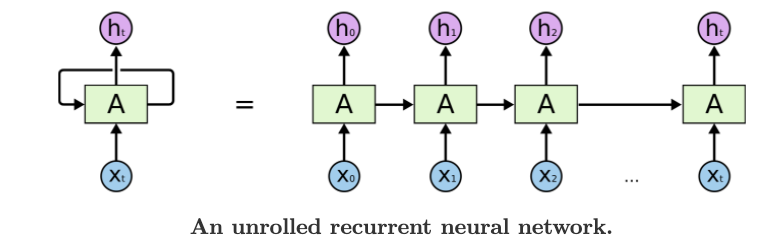

In [53]:
from IPython.display import Image
Image(filename='img/RNN.png')

1. A single time step of the input is supplied to the network i.e. xt is supplied to the network
2. We then calculate its current state using a combination of the current input and the previous state i.e. we calculate ht
3. The current ht becomes ht-1 for the next time step
4. We can go as many time steps as the problem demands and combine the information from all the previous states
5. Once all the time steps are completed the final current state is used to calculate the output yt
6. The output is then compared to the actual output and the error is generated
7. The error is then backpropagated to the network to update the weights and the network is trained

In [54]:
input = Input(shape=(max_seq_length,), dtype='int32')
hl1_embedded = Embedding(input_dim=vocab_size, 
                         output_dim=embedding_vector_length,
                         weights=[embedding_matrix],
                         trainable=True)(input)
h12_rnn = SimpleRNN(100)(hl1_embedded)
h13_dropout = Dropout(0.2)(h12_rnn)
output = Dense(2, activation='softmax')(h13_dropout)

model = Model(input, output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 100)          8858800   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 8,879,102
Trainable params: 8,879,102
Non-trainable params: 0
_________________________________________________________________


In [55]:
(100+100)*100+100

20100

* The formula for calculating the weights is as follows:

      (num_features + num_units)* num_units + num_units

    Explanation:

      num_units = equals the number of units in the RNN

      num_features = equals the number features of your input

`= (100 + 100) * 100 + 100 = 20100`

In [56]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
model.fit(X_train, y_train, epochs=2,
          validation_data=(X_test, y_test),
          batch_size=128)

Epoch 1/2
196/196 [==============================] - 106s 533ms/step - loss: 0.7064 - accuracy: 0.5012 - val_loss: 0.6965 - val_accuracy: 0.5082
Epoch 2/2
196/196 [==============================] - 115s 585ms/step - loss: 0.7120 - accuracy: 0.5095 - val_loss: 0.6932 - val_accuracy: 0.5073


In [58]:
Y_pred = model.predict(X_test)
print(Y_pred[0:5])

[[0.54083455 0.45916548]
 [0.5408345  0.4591655 ]
 [0.6529312  0.34706885]
 [0.54083455 0.45916548]
 [0.5408345  0.4591655 ]]


In [59]:
y_pred =[]
for i in Y_pred:
    y_pred.append(np.argmax(i))

In [60]:
print(y_pred[0:5])

[0, 0, 0, 0, 0]


In [61]:
metrics.confusion_matrix(y_test_actual, y_pred)

array([[11883,   617],
       [11700,   800]])

In [62]:
metrics.accuracy_score(y_test_actual, y_pred)

0.50732

In [63]:
metrics.precision_score(y_test_actual, y_pred)

0.5645730416372619

In [64]:
metrics.recall_score(y_test_actual, y_pred)

0.064

### LSTM
    * LSTM does better than RNN in capturing long-term dependencies.

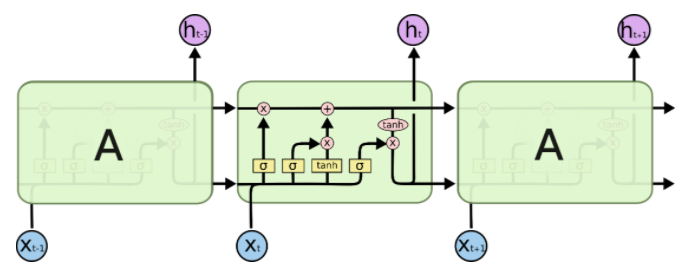

In [65]:
Image(filename='img/LSTM.png')

* The first layer is the Embedded layer that uses 100 length vectors to represent each word. 

* The next layer is the LSTM layer with 100 memory units (smart neurons). 

* Finally, because this is a classification problem we use a Dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (good and bad) in the problem.

In [66]:
input = Input(shape=(max_seq_length,), dtype='int32')
hl1_embedded = Embedding(input_dim=vocab_size, 
                         output_dim=embedding_vector_length,
                         weights=[embedding_matrix],
                         trainable=True)(input)
h12_lstm = LSTM(100)(hl1_embedded)
h13_dropout = Dropout(0.2)(h12_lstm)
output = Dense(2, activation='softmax')(h13_dropout)

model = Model(input, output)

In [67]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 500, 100)          8858800   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 202       
                                                                 
Total params: 8,939,402
Trainable params: 8,939,402
Non-trainable params: 0
_________________________________________________________________


### Number of parameters of an LSTM layer

`num_params = [(num_units + input_dim) * num_units+num_units]  * 4`

  * *4: there are 4 neural network layers - {W_forget, W_input, W_output, W_cell}

`num_params = [(100 + 100) * 100 + 100] * 4 = 80400`

https://stackoverflow.com/questions/38080035/how-to-calculate-the-number-of-parameters-of-an-lstm-network/56614978#56614978

In [68]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


The model is fit for only 5 epochs because it quickly overfits the problem. 

In [69]:
model.fit(X_train, y_train, epochs=2,
          validation_data=(X_test, y_test),
          batch_size=128)

Epoch 1/2
196/196 [==============================] - 327s 2s/step - loss: 0.6915 - accuracy: 0.5075 - val_loss: 0.6885 - val_accuracy: 0.5152
Epoch 2/2
196/196 [==============================] - 318s 2s/step - loss: 0.6853 - accuracy: 0.5194 - val_loss: 0.6871 - val_accuracy: 0.5161


#### Make predictions on test data

In [70]:
Y_pred = model.predict(X_test)
print(Y_pred[0:5])

[[0.55326647 0.44673356]
 [0.55326647 0.44673356]
 [0.6876303  0.31236973]
 [0.55326647 0.44673356]
 [0.55326647 0.44673353]]


In [71]:
y_pred =[]
for i in Y_pred:
    y_pred.append(np.argmax(i))

In [72]:
print(y_pred[0:5])

[0, 0, 0, 0, 0]


In [73]:
metrics.confusion_matrix(y_test_actual, y_pred)

array([[12342,   158],
       [11940,   560]])

In [74]:
metrics.accuracy_score(y_test_actual, y_pred)

0.51608

In [75]:

metrics.precision_score(y_test_actual, y_pred)

0.7799442896935933

In [76]:
metrics.recall_score(y_test_actual, y_pred)

0.0448

### Bidirectional LSTM
    * Bidirectional recurrent neural networks(RNN) are just putting two independent RNNs together. 
    * The input sequence is fed in normal time order for one network, and in reverse time order for another. 
    * The outputs of the two networks are usually concatenated at each time step.
    * This structure allows the networks to have both backward and forward information about the sequence at every  time step.

In [77]:
inputs = Input(shape=(max_seq_length,), dtype='int32')

# Embed each integer in a 100-dimensional vector
hl1_embedded = Embedding(input_dim=vocab_size, 
                         output_dim=embedding_vector_length,
                         weights=[embedding_matrix],
                         trainable=True)(inputs)

# Add a bidirectional LSTM
x = Bidirectional(LSTM(100))(hl1_embedded)# Add a classifier
outputs = Dense(2, activation="softmax")(x)

model = Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 500, 100)          8858800   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 2)                 402       
                                                                 
Total params: 9,020,002
Trainable params: 9,020,002
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for only 5 epochs because it quickly overfits the problem. 

In [80]:
model.fit(X_train, y_train, epochs=2,
          validation_data=(X_test, y_test),
          batch_size=128)

Epoch 1/2
196/196 [==============================] - 612s 3s/step - loss: 0.0331 - accuracy: 0.9919 - val_loss: 0.5433 - val_accuracy: 0.8483
Epoch 2/2
196/196 [==============================] - 593s 3s/step - loss: 0.0177 - accuracy: 0.9962 - val_loss: 0.6792 - val_accuracy: 0.8477


#### Make predictions on test data

In [81]:
Y_pred = model.predict(X_test)
print(Y_pred[0:5])

[[9.9974281e-01 2.5713560e-04]
 [1.5037902e-07 9.9999988e-01]
 [4.6997095e-05 9.9995303e-01]
 [9.9965024e-01 3.4969885e-04]
 [7.6812035e-01 2.3187965e-01]]


In [82]:
y_pred =[]
for i in Y_pred:
    y_pred.append(np.argmax(i))

In [83]:
print(y_pred[0:5])

[0, 1, 1, 0, 0]


In [84]:
metrics.confusion_matrix(y_test_actual, y_pred)

array([[10435,  2065],
       [ 1743, 10757]])

In [85]:
metrics.accuracy_score(y_test_actual, y_pred)

0.84768

In [86]:
metrics.precision_score(y_test_actual, y_pred)

0.8389486819528935

In [87]:
metrics.recall_score(y_test_actual, y_pred)

0.86056

### Stacked Bidirectional LSTM

In [88]:
inputs = Input(shape=(max_seq_length,), dtype='int32')

# Embed each integer in a 100-dimensional vector
embedded = Embedding(input_dim=vocab_size, 
                     output_dim=embedding_vector_length,
                     weights=[embedding_matrix],
                     trainable=True)(inputs)

# Add a bidirectional LSTM
h1_biLSTM = Bidirectional(LSTM(100, return_sequences=True))(embedded)
h2_biLSTM = Bidirectional(LSTM(100))(h1_biLSTM)

outputs = Dense(2, activation="softmax")(h2_biLSTM)

model = Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 500, 100)          8858800   
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 200)         160800    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 2)                 402       
                                                                 
Total params: 9,260,802
Trainable params: 9,260,802
Non-tra

In [89]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for only 5 epochs because it quickly overfits the problem. 

In [91]:
model.fit(X_train, y_train, epochs=1,
          validation_data=(X_test, y_test),
          batch_size=128)

196/196 [==============================] - 1405s 7s/step - loss: 0.5623 - accuracy: 0.7157 - val_loss: 0.4471 - val_accuracy: 0.8045


#### Make predictions on test data

In [92]:
Y_pred = model.predict(X_test)
print(Y_pred[0:5])

[[0.42436853 0.5756315 ]
 [0.01682253 0.9831775 ]
 [0.25861    0.74139   ]
 [0.94583803 0.05416198]
 [0.04550564 0.95449436]]


In [93]:
y_pred =[]
for i in Y_pred:
    y_pred.append(np.argmax(i))

In [94]:


print(y_pred[0:5])

[1, 1, 1, 0, 1]


In [95]:

metrics.confusion_matrix(y_test_actual, y_pred)

array([[ 9918,  2582],
       [ 2306, 10194]])

In [96]:
metrics.accuracy_score(y_test_actual, y_pred)

0.80448

In [97]:

metrics.precision_score(y_test_actual, y_pred)

0.7979023168440826

In [98]:
metrics.recall_score(y_test_actual, y_pred)

0.81552

__References:__

    * https://machinelearningmastery.com
    * https://keras.io
    * http://colah.github.io/posts/2015-08-Understanding-LSTMs/
    * https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9
    * https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
    * https://www.analyticsvidhya.com/blog/2017/12/introduction-to-recurrent-neural-networks/
    * https://devopedia.org/bidirectional-rnn
    * https://towardsdatascience.com/counting-no-of-parameters-in-deep-learning-models-by-hand-8f1716241889